# Importing Libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [3]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [6]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [7]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [9]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [10]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [11]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [12]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [13]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [14]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_13192\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [15]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [16]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()

In [17]:
holding=Binance.get_inventory()

In [18]:
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT').round(2)

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.94,4656.50,1.00,-131.89,2471.56,2339.67
OMUSDT,526.32,2815.05,0.60,0.00,2288.73,2288.73
BTCUSDT,601.02,860.20,0.18,3.54,259.17,262.71
SOLUSDT,281.20,359.06,0.08,0.00,77.85,77.85
JASMYUSDT,387.46,295.90,0.06,0.00,-91.56,-91.56
ETHUSDT,250.75,184.48,0.04,0.00,-66.27,-66.27
TRXUSDT,76.87,119.11,0.03,-10.72,42.25,31.53
BBUSDT,60.18,21.66,0.00,-39.73,-38.51,-78.24
BNBUSDT,1.14,1.04,0.00,-10.61,-0.10,-10.71
PEPEUSDT,0.00,0.00,0.00,-38.52,-0.00,-38.52


In [19]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining

437

In [20]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [21]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [22]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [23]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [24]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [25]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [27]:
position=pd.read_excel('Positions.xlsx',index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [28]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx')

quantities_tickers=list(quantities.columns)

In [29]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [30]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [31]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()

for col in quantities:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index]

In [32]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [33]:
# pnl_history['Total']

In [34]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [35]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [36]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [37]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in quantities:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [38]:
pnl_history['Total']

2024-09-23    -242.846960
2024-09-24    -351.229838
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2025-02-05    2199.786173
2025-02-06    2196.544551
2025-02-07    2277.788822
2025-02-08    2223.713748
2025-02-09    2500.096297
Name: Total, Length: 140, dtype: float64

In [39]:
pnl_history['Total']-pnl_history['Total'].shift(1)

2024-09-23           NaN
2024-09-24   -108.382879
2024-09-25    -11.102127
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2025-02-05    -39.906169
2025-02-06     -3.241622
2025-02-07     81.244272
2025-02-08    -54.075075
2025-02-09    276.382550
Name: Total, Length: 140, dtype: float64

In [40]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [41]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [42]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [43]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


C:\Users\Admin\AppData\Local\Temp\ipykernel_13192\974280261.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  binance_data=np.log(1+binance_data.pct_change())


In [44]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [45]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [46]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<Axes: >

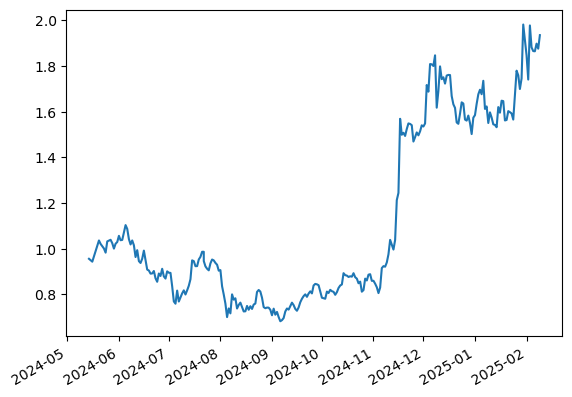

In [47]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

<Axes: >

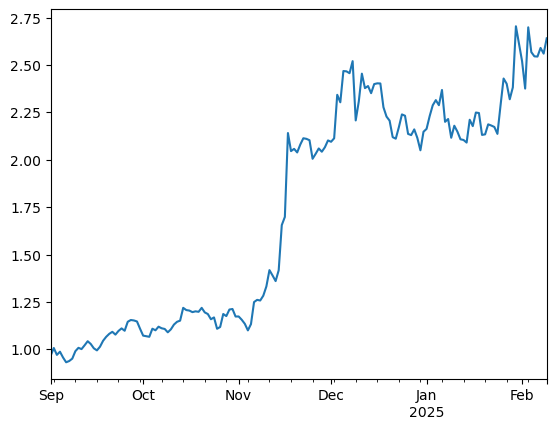

In [48]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()

## Ex ante data

In [50]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [53]:
days=0
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [54]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [57]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
OMUSDT,0.5050
BNBUSDT,0.1916
XRPUSDT,0.1348
SUIUSDT,0.0506
PEPEUSDT,0.0415
DEXEUSDT,0.0326
TRXUSDT,0.0228
RAYUSDT,0.0138
AAVEUSDT,0.0072
BTCUSDT,0.0000


In [58]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.462176
BTCUSDT,0.300000
XRPUSDT,0.084005
BNBUSDT,0.068168
SUIUSDT,0.033928
DEXEUSDT,0.026534
TRXUSDT,0.018122
PEPEUSDT,0.004900
RAYUSDT,0.002167


In [59]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))
tickers_frontier.remove('BBUSDT')

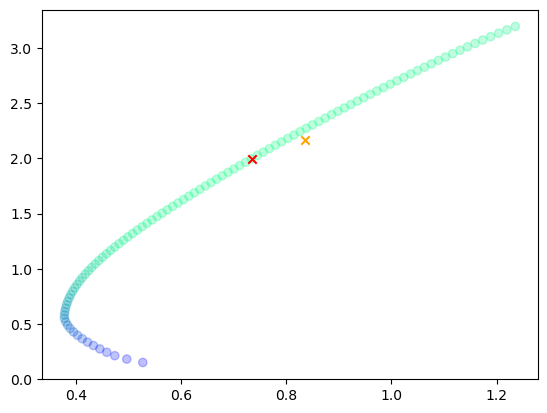

In [60]:
days=0
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

In [61]:
frontier_analysis.inventory(frontier_opt_weights).round(6)

,Weights
OMUSDT,0.251712
XRPUSDT,0.136335
BNBUSDT,0.097548
SUIUSDT,0.051272
DEXEUSDT,0.033960
PEPEUSDT,0.020898
RAYUSDT,0.014574
TRXUSDT,0.011772
ETHUSDT,0.000000
BTCUSDT,0.000000


<Axes: >

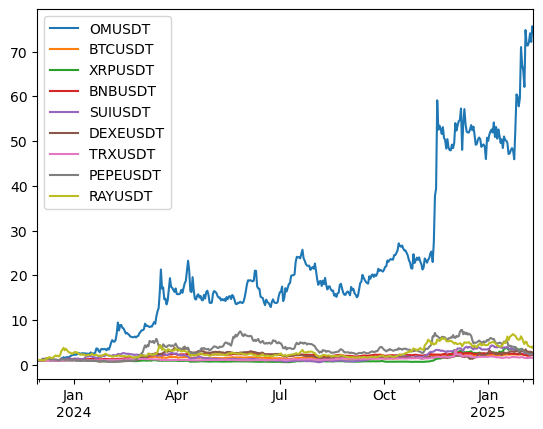

In [62]:
(1+returns_to_use[inventory.index].iloc[:]).cumprod().plot()

### Current results

In [64]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [65]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
OMUSDT,0.555261
BTCUSDT,0.311048
TRXUSDT,0.133692


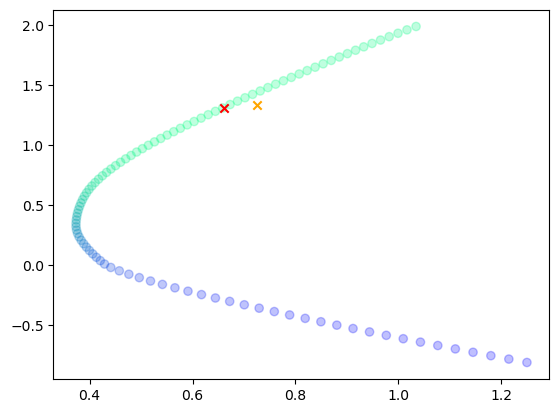

In [66]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

## Real Portfolio vs Optimal

In [68]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,2815.047826,0.604542,0.555261,0.049281
BTCUSDT,860.195537,0.184730,0.311048,-0.126318
SOLUSDT,359.055459,0.077108,0.000000,0.077108
JASMYUSDT,295.899819,0.063546,0.000000,0.063546
ETHUSDT,184.476986,0.039617,0.000000,0.039617
TRXUSDT,119.114301,0.025580,0.133692,-0.108112
BBUSDT,21.664310,0.004653,0.000000,0.004653
BNBUSDT,1.041435,0.000224,0.000000,0.000224
PEPEUSDT,0.000002,0.000000,0.000000,0.000000


In [69]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,2815.047826,0.604542,0.462176,0.142366
BTCUSDT,860.195537,0.184730,0.300000,-0.115270
SOLUSDT,359.055459,0.077108,0.000000,0.077108
JASMYUSDT,295.899819,0.063546,0.000000,0.063546
ETHUSDT,184.476986,0.039617,0.000000,0.039617
TRXUSDT,119.114301,0.025580,0.018122,0.007458
BBUSDT,21.664310,0.004653,0.000000,0.004653
BNBUSDT,1.041435,0.000224,0.068168,-0.067944
PEPEUSDT,0.000002,0.000000,0.004900,-0.004900
XRPUSDT,0.000000,0.000000,0.084005,-0.084005


# Risk Reward Analysis

In [71]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [72]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<Axes: >

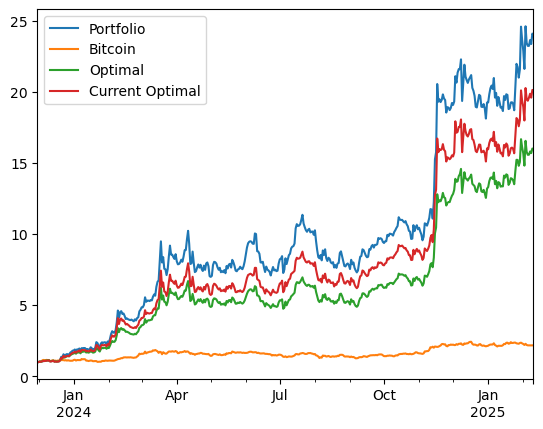

In [73]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()

In [74]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<Axes: >

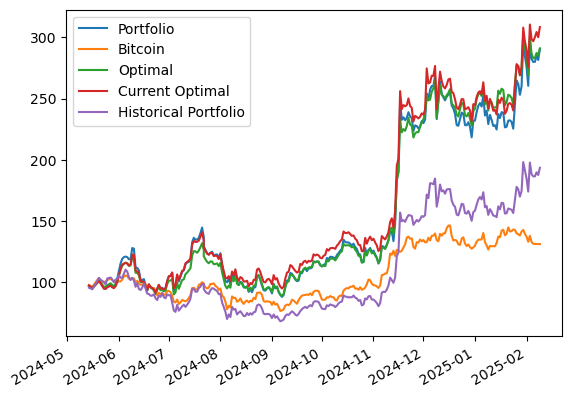

In [75]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()

In [76]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2025-01-31,284.884248,139.657879,292.566595,296.607482,191.324410
2025-02-01,275.822797,137.190295,284.687809,290.117490,184.686080
2025-02-02,260.424363,133.129604,269.146790,275.516636,174.094032
2025-02-03,296.530109,137.983551,300.794603,310.428328,197.785838
2025-02-04,282.365875,133.040925,286.611178,298.381816,188.190244
2025-02-05,279.927841,131.465707,282.936778,296.777211,186.561035
2025-02-06,279.916948,131.386650,283.086230,300.084342,186.471769
2025-02-07,284.896852,131.321931,287.219803,304.304513,189.817980
2025-02-08,281.484576,131.237455,285.145120,300.069618,187.609350
2025-02-09,290.332636,131.261960,290.971099,308.329720,193.532660


## Volatilities

In [78]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.678734
 dtype: float64,
 0.6794883289323136)

In [79]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.725085
 dtype: float64,
 0.725085353480609)

In [80]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.835093
Bitcoin            0.424957
Optimal            0.679488
Current Optimal    0.760109
dtype: float64

In [81]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.4678054647297071

In [82]:
days=90
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

2.5407081305273826

In [83]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

1.8299409987706472

## Risk Contribution

In [85]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.083334,0.068168,0.004257,0.019676,0.002222,0.017454
BTCUSDT,0.360869,0.300000,0.018571,0.105699,0.035202,0.070497
DEXEUSDT,0.045784,0.026534,0.002032,0.013802,0.001312,0.012490
OMUSDT,33.874687,0.462176,0.964870,0.799318,0.706545,0.092773
PEPEUSDT,0.007158,0.004900,0.000339,0.003251,0.000080,0.003170
RAYUSDT,0.006936,0.002167,0.000256,0.001707,0.000014,0.001693
SUIUSDT,0.051361,0.033928,0.002397,0.017251,0.002263,0.014988
TRXUSDT,0.012676,0.018122,0.000865,0.004519,0.000320,0.004198
XRPUSDT,0.144233,0.084005,0.006414,0.034777,0.006970,0.027807


In [86]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,2.242824,0.555261,0.815437,0.841654,0.756933,0.084721
BTCUSDT,0.129660,0.311048,0.128434,0.095193,0.035584,0.059610
TRXUSDT,0.058910,0.133692,0.056129,0.063152,0.027523,0.035629


In [87]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,2.448015,0.606061,0.869237,0.838184,0.747504,0.090680
BTCUSDT,0.075790,0.181818,0.073319,0.052460,0.010078,0.042382
SOLUSDT,0.005948,0.080808,0.024692,0.041840,0.005492,0.036348
JASMYUSDT,-0.020297,0.060606,0.011473,0.044366,0.008579,0.035787
ETHUSDT,-0.009296,0.040404,0.008854,0.013400,0.000918,0.012481
TRXUSDT,0.013353,0.030303,0.012425,0.009751,0.001172,0.008579


# Value At Risk

## Historical

### Optimal Weights

In [91]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.051074942539763746, -0.07763898322828998)

### Current Weights

In [93]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.050479628181940205, -0.07626454203778874)

In [94]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [95]:
var=historical_var.iloc[row]
var

OMUSDT      -0.029983
BTCUSDT     -0.005696
SOLUSDT     -0.003001
JASMYUSDT   -0.008437
ETHUSDT     -0.001147
TRXUSDT     -0.001750
BBUSDT      -0.000000
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.050015
Name: 2025-01-19 00:00:00, dtype: float64

In [96]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.057411
BTCUSDT     -0.004863
SOLUSDT     -0.004254
JASMYUSDT   -0.005262
ETHUSDT     -0.001696
TRXUSDT     -0.001028
BBUSDT       0.000000
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.074515
dtype: float64

## Parametric

### Optimal Weights

In [99]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.07040588922331419, -0.09024088383401749)

### Current Weights

In [101]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.07513047229938319, -0.09629649306266319)

## Multivariate

### Optimal Weights

In [104]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06332112116128204, -0.08128190794789955)

### Current Weights

In [106]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.0702718144235173, -0.08908790406179999)

In [107]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.057132
BTCUSDT     -0.004289
SOLUSDT     -0.003145
JASMYUSDT   -0.003205
ETHUSDT     -0.001066
TRXUSDT     -0.000804
Portfolio   -0.069641
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [111]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06266077800572778, -0.07945247034953345)

### Current Weights

In [113]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06987501518369536, -0.08903244056473486)

In [114]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.057542
BTCUSDT     -0.003943
SOLUSDT     -0.003243
JASMYUSDT   -0.003295
ETHUSDT     -0.001002
TRXUSDT     -0.000635
Portfolio   -0.069661
dtype: float64

## Student Copula

### Optimal Weights

In [117]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06269265210095994, -0.08202907070179082)

### Current Weights

In [119]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07133145690194884, -0.09335475582033559)

In [120]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.061002
BTCUSDT     -0.002879
SOLUSDT     -0.002669
JASMYUSDT   -0.003251
ETHUSDT     -0.000743
TRXUSDT     -0.000713
Portfolio   -0.071257
dtype: float64

## Gumbel Copula

### Optimal Weights

In [123]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.12399777328930393, -0.1795673797274276)

### Current Weights

In [125]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.137868754220882, -0.195790854350076)

In [126]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.136330
BTCUSDT     -0.000913
SOLUSDT     -0.001748
JASMYUSDT   -0.000766
ETHUSDT      0.000150
TRXUSDT     -0.000260
Portfolio   -0.139868
dtype: float64

## Monte Carlo

### Optimal

In [129]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [130]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07231238221330455, -0.09016233107153344)

### Current Weights

In [132]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07685983135532802, -0.09434444918703255)

In [133]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.062708
BTCUSDT     -0.004110
SOLUSDT     -0.003563
JASMYUSDT   -0.004246
ETHUSDT     -0.001072
TRXUSDT     -0.000986
Portfolio   -0.076685
dtype: float64

## VaR Violation

In [135]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.058486,-0.105071,-0.087664,-0.020755
2024-01-15,-0.058486,-0.105053,-0.088268,0.017829
2024-01-16,-0.058486,-0.105187,-0.086199,0.052271
2024-01-17,-0.058486,-0.107391,-0.089467,-0.033059
2024-01-18,-0.058486,-0.109527,-0.094048,-0.033256
...,...,...,...,...
2025-02-06,-0.052851,-0.097099,-0.091509,0.000528
2025-02-07,-0.052851,-0.097046,-0.090856,0.014602
2025-02-08,-0.052851,-0.095360,-0.089892,-0.007223
2025-02-09,-0.052851,-0.094877,-0.087708,0.020432


In [136]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.041301,-0.083388,-0.081793,-0.015412
2024-05-29,-0.041301,-0.081187,-0.079505,-0.007243
2024-05-30,-0.041301,-0.070995,-0.070938,0.027543
2024-05-31,-0.041301,-0.074052,-0.068804,0.044522
2024-06-01,-0.041301,-0.079348,-0.072873,0.060699
...,...,...,...,...
2025-02-06,-0.054699,-0.152424,-0.134210,-0.000039
2025-02-07,-0.054699,-0.151892,-0.131897,0.017791
2025-02-08,-0.054699,-0.150849,-0.133335,-0.011977
2025-02-09,-0.054699,-0.144030,-0.129525,0.031434


<Axes: >

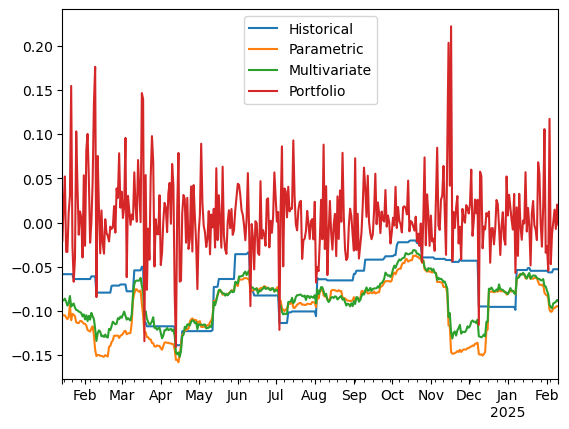

In [137]:
var_data.plot()

<Axes: >

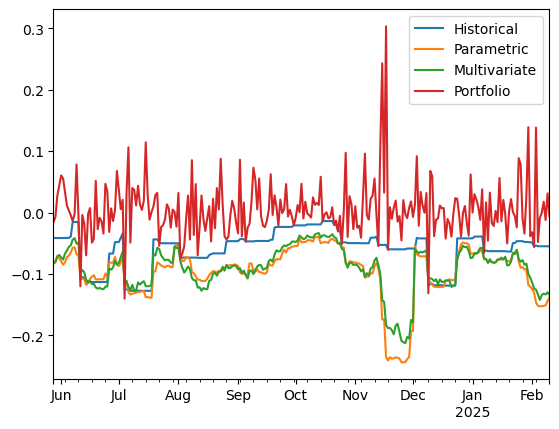

In [138]:
current_var_data.plot()

In [139]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.022843,0.007614,0.010152
Kupiec Stat,7.601911,22.842219,19.294923
P-value,0.005831,0.000002,0.000011


In [140]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.057915,0.015444,0.011583
Kupiec Stat,0.32576,8.823265,11.52215
P-value,0.568167,0.002974,0.000688


# Principal Component Analysis

## Historical PCA

In [143]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.78589947, 0.06801608, 0.05585549, 0.05007096, 0.040158  ])

In [144]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.016180
ADAUSDT     0.016137
ALGOUSDT    0.018604
APTUSDT     0.016801
ARBUSDT     0.018000
              ...   
WBTCUSDT    0.009161
WLDUSDT     0.022643
XLMUSDT     0.013474
XRPUSDT     0.011617
XTZUSDT     0.016705
Name: PC1, Length: 61, dtype: float64

<Axes: >

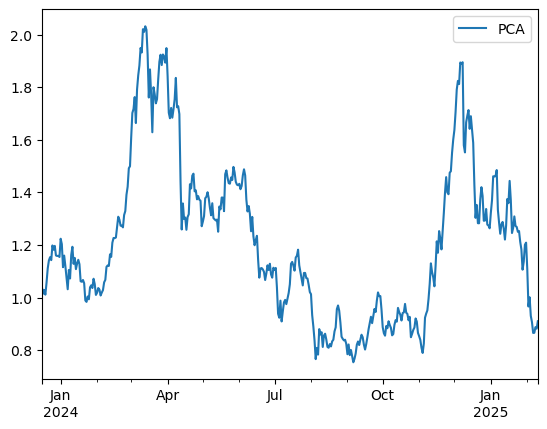

In [145]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<Axes: >

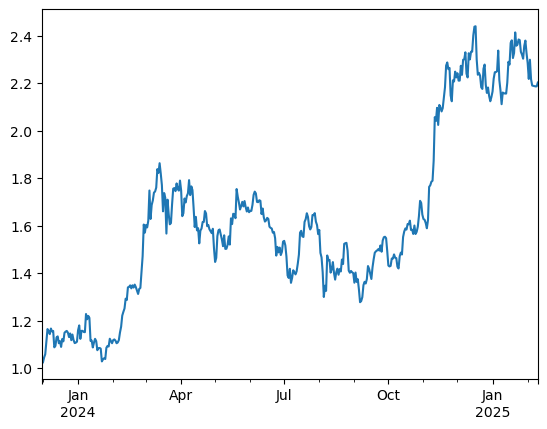

In [146]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [147]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
FLOWUSDT     0.426617
WBETHUSDT    0.445658
ETHUSDT      0.445919
ATOMUSDT     0.463882
DOTUSDT      0.464586
ETCUSDT      0.468908
NEXOUSDT     0.481731
ADAUSDT      0.508169
EOSUSDT      0.526163
WBTCUSDT     0.528914
BTCUSDT      0.529457
AVAXUSDT     0.532240
IOTAUSDT     0.552244
FILUSDT      0.561504
ARBUSDT      0.570243
GRTUSDT      0.579733
XTZUSDT      0.584980
LINKUSDT     0.598097
IMXUSDT      0.610156
dtype: float64

<Axes: >

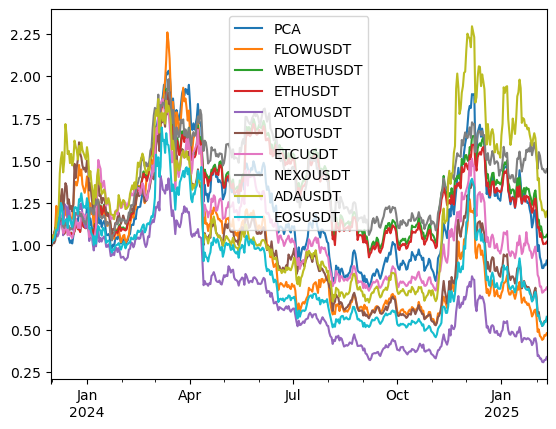

In [148]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<Axes: >

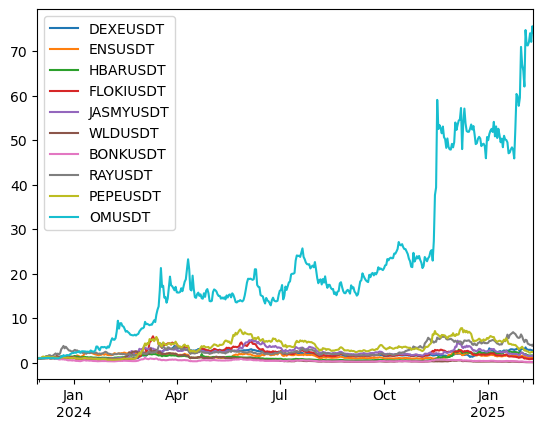

In [149]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [151]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.56854356, 0.14764136, 0.11847481, 0.09459254, 0.07074774])

In [152]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.094837
BTCUSDT      0.059033
SOLUSDT      0.097890
JASMYUSDT    0.176086
ETHUSDT      0.084383
TRXUSDT      0.055475
BBUSDT       0.206681
BNBUSDT      0.065586
PEPEUSDT     0.160030
Name: PC1, dtype: float64

<Axes: >

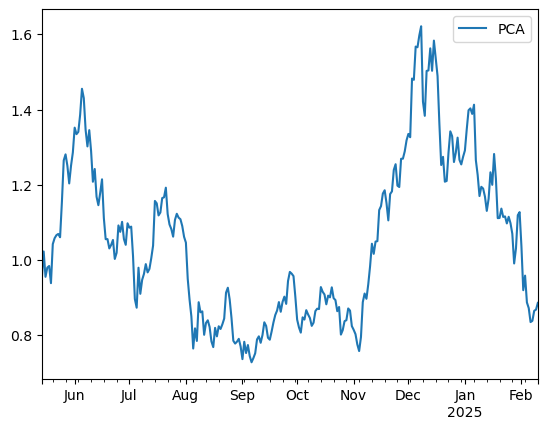

In [153]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<Axes: >

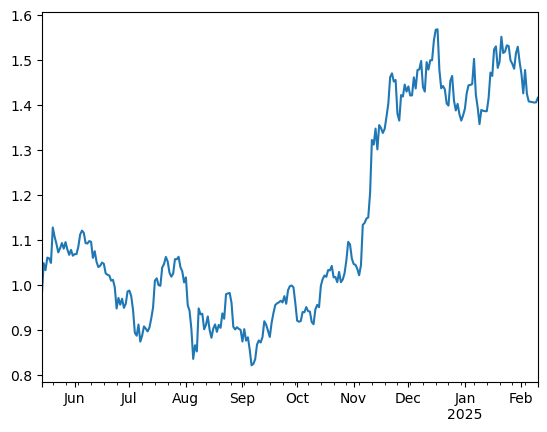

In [154]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [155]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.437092
BNBUSDT      0.470635
BTCUSDT      0.492910
SOLUSDT      0.493351
JASMYUSDT    0.693196
PEPEUSDT     0.746036
BBUSDT       0.778425
TRXUSDT      0.907096
OMUSDT       0.979549
dtype: float64

<Axes: >

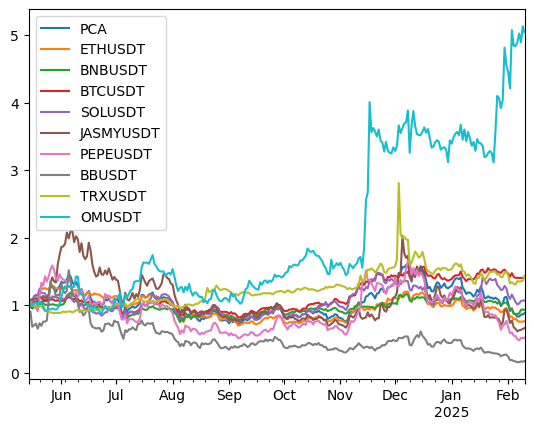

In [156]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [158]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.907850
BBUSDT       1.572944
JASMYUSDT    1.344361
SOLUSDT      1.165953
BTCUSDT      1.000000
ETHUSDT      0.972117
OMUSDT       0.894026
BNBUSDT      0.666732
TRXUSDT      0.328785
Name: BTCUSDT, dtype: float64

In [159]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

JASMYUSDT    2.581539
PEPEUSDT     2.254014
BBUSDT       2.035561
SOLUSDT      1.446798
OMUSDT       1.147166
ETHUSDT      1.141214
TRXUSDT      1.039337
BTCUSDT      1.000000
BNBUSDT      0.763503
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [161]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [162]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
BTCUSDT,0.378462
BBUSDT,0.318624
TRXUSDT,0.163829
ETHUSDT,0.138121
SOLUSDT,0.096910
PEPEUSDT,0.087758
JASMYUSDT,0.084384
OMUSDT,0.017285
BNBUSDT,-0.047908


### Regression to PCA

In [164]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

0.6604563136700611

In [165]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.303897
BNBUSDT      1.171351
ETHUSDT      1.026818
PCA          1.000000
SOLUSDT      0.751920
JASMYUSDT    0.441272
PEPEUSDT     0.417621
BBUSDT       0.387168
TRXUSDT      0.265304
OMUSDT       0.242350
dtype: float64

In [166]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.896531
BNBUSDT      1.466684
ETHUSDT      1.237145
TRXUSDT      1.082787
PCA          1.000000
BBUSDT       0.681809
PEPEUSDT     0.635555
JASMYUSDT    0.518615
SOLUSDT      0.459828
OMUSDT       0.284089
dtype: float64

### Correlation Matrix

<Axes: >

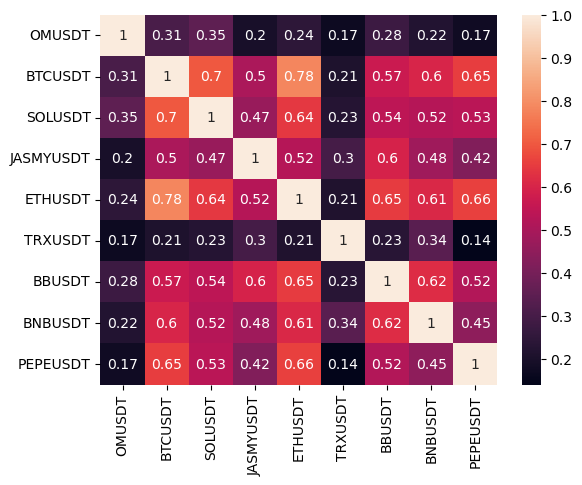

In [168]:
sns.heatmap(ex_ante_perf.corr(),annot=True)

<Axes: >

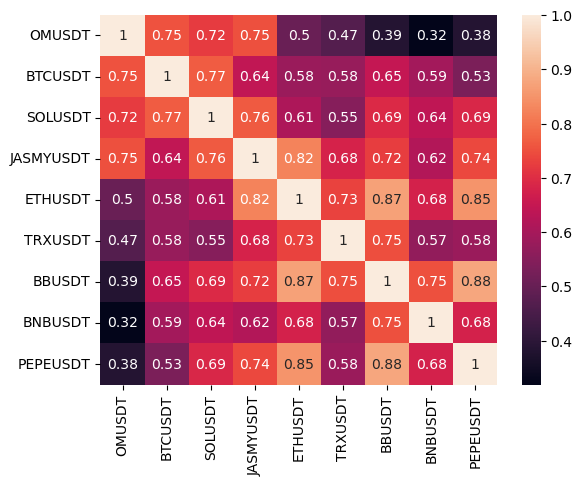

In [169]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

## Sliding window optimization

In [171]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,SOLUSDT,JASMYUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.000000,0.621968,0.000000,0.000000,0.000000,0.000000,0.378032
2024-06-10,0.625939,0.000000,0.000000,0.150852,0.000000,0.223209,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.182528,0.000000,0.000000,0.000000,0.000000,0.817472,0.000000,0.000000,0.000000
2024-07-22,0.133242,0.414563,0.112009,0.000000,0.000000,0.340186,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926694,0.000000,0.073306,0.000000
2024-09-02,0.435138,0.000000,0.000000,0.000000,0.000000,0.564862,0.000000,0.000000,0.000000
2024-09-16,0.287440,0.000000,0.000000,0.000000,0.000000,0.000000,0.712560,0.000000,0.000000
2024-09-30,0.176666,0.000000,0.000000,0.000000,0.165949,0.527049,0.000000,0.000000,0.130336


In [172]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BONKUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-07-05,0.007546,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.992454,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-08-04,0.588346,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.411654,0.0
2024-09-03,0.384694,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.517899,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-10-03,0.125131,0.0,0.000000,0.062096,0.0,0.0,0.0,0.0,0.0,0.0,...,0.324388,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-11-02,0.007546,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.516429,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-12-02,0.007546,0.0,0.007581,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.034553,0.365287,0.0
2025-01-01,0.572760,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2025-01-31,0.007546,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.389617,0.0
2025-02-10,0.007546,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [173]:
rolling_optimization.iloc[-1].sort_values(ascending=False)[:6]

OMUSDT      0.992454
AAVEUSDT    0.007546
LDOUSDT     0.000000
LTCUSDT     0.000000
MKRUSDT     0.000000
NEARUSDT    0.000000
Name: 2025-02-10 00:00:00, dtype: float64